In [116]:
import pandas as pd
import pyodbc
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from prettytable import PrettyTable
from sqlalchemy import create_engine, Column, Integer, String, MetaData, Table
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
#import function to calculate pariwise distance 
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split

# geting data from Sql Server

In [117]:
# Get a list of available ODBC drivers
drivers = [driver for driver in pyodbc.drivers()]

# Display the list of drivers
print("Available ODBC Drivers:")
for driver in drivers:
    print(driver)

Available ODBC Drivers:
SQL Server
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server
Microsoft Access Driver (*.mdb, *.accdb)
Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)
Microsoft Access Text Driver (*.txt, *.csv)


In [118]:
conn_odbc_17 = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};''SERVER={AW-13-WATAMBE};''DATABASE={BookR};''Trusted_Connection=yes')
cursor=conn_odbc_17.cursor()

book= pd.read_sql_query("SELECT * FROM Books",conn_odbc_17)
Rating=pd.read_sql_query("SELECT * FROM Ratings",conn_odbc_17)
User=pd.read_sql_query("SELECT * FROM Users",conn_odbc_17)

C:\Users\astik\AppData\Local\Temp\ipykernel_16292\3009954324.py:4: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\astik\AppData\Local\Temp\ipykernel_16292\3009954324.py:5: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



C:\Users\astik\AppData\Local\Temp\ipykernel_16292\3009954324.py:6: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# chake the tables 

In [119]:
book.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [120]:
User.head()

,User_ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [121]:
Rating.head()

,User_ID,ISBN,Book_Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# chaking info of tabel

In [122]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book_Title           271360 non-null  object
 2   Book_Author          271359 non-null  object
 3   Year_Of_Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image_URL_S          271360 non-null  object
 6   Image_URL_M          271360 non-null  object
 7   Image_URL_L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [123]:
User.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User_ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [124]:
Rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User_ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book_Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


# find null value

In [125]:
book.isnull().sum()

ISBN                   0
Book_Title             0
Book_Author            1
Year_Of_Publication    0
Publisher              2
Image_URL_S            0
Image_URL_M            0
Image_URL_L            3
dtype: int64

In [126]:
User.isnull().sum()

User_ID          0
Location         0
Age         110762
dtype: int64

In [127]:
Rating.isnull().sum()

User_ID        0
ISBN           0
Book_Rating    0
dtype: int64

# find non integer  value

In [128]:
a = pd.to_numeric(book['Year_Of_Publication'], errors='coerce')
idx = a.isna()
book[idx]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,None
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,None
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,None


#

In [129]:
book.loc[book['Year_Of_Publication'] == 'DK Publishing Inc',:]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,None
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,None


In [130]:
book.loc[book['ISBN']== '0789466953','Year_Of_Publication']=2000
book.loc[book["ISBN"]=='0789466953','Book_Author']="James Buckley"  
book.loc[book["ISBN"]=='0789466953','Publisher']='DK Publishing Inc'


In [131]:
book.loc[book['ISBN']== '2070426769','Year_Of_Publication']=2000
book.loc[book["ISBN"]=='2070426769','Book_Author']="Jean-Marie Gustave Le ClÃƒ?Ã‚Â©zio"
book.loc[book["ISBN"]=='2070426769','Publisher']='Gallimard'


In [132]:
book.loc[book['ISBN']=='078946697X','Year_Of_Publication']=2000
book.loc[book["ISBN"]=='078946697X','Book_Author']="michael Teiteibaum"
book.loc[book["ISBN"]=='078946697X','Publisher']='DK Publishing Inc'


In [133]:
book.loc[book['ISBN'] == '0789466953',:]
book.loc[book['ISBN'] == '2070426769',:]
book.loc[book['ISBN'] == '078946697X',:]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",michael Teiteibaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,None


In [134]:

book = pd.DataFrame(book)

In [135]:
book.rename_axis('Bindex', inplace=True)

In [136]:
a = pd.to_numeric(book['ISBN'], errors='coerce')
idx = a.isna()
book[idx]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
Bindex,,,,,,,,
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...
11,080652121X,Hitler's Secret Bankers: The Myth of Swiss Neu...,Adam Lebor,2000,Citadel Press,http://images.amazon.com/images/P/080652121X.0...,http://images.amazon.com/images/P/080652121X.0...,http://images.amazon.com/images/P/080652121X.0...
40,038078243X,Miss Zukas and the Raven's Dance,Jo Dereske,1996,Avon,http://images.amazon.com/images/P/038078243X.0...,http://images.amazon.com/images/P/038078243X.0...,http://images.amazon.com/images/P/038078243X.0...
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.amazon.com/images/P/055321215X.0...,http://images.amazon.com/images/P/055321215X.0...,http://images.amazon.com/images/P/055321215X.0...
42,067176537X,The Therapeutic Touch: How to Use Your Hands t...,Dolores Krieger,1979,Fireside,http://images.amazon.com/images/P/067176537X.0...,http://images.amazon.com/images/P/067176537X.0...,http://images.amazon.com/images/P/067176537X.0...
...,...,...,...,...,...,...,...,...
271323,000637610X,You Got an Ology,Maureen Lipman,1990,HarperCollins Publishers,http://images.amazon.com/images/P/000637610X.0...,http://images.amazon.com/images/P/000637610X.0...,http://images.amazon.com/images/P/000637610X.0...
271335,381440176X,"Ein Fall fÃ?Â¼r TKKG, Bd.50, Sklaven fÃ?Â¼r Wu...",Stefan Wolf,1989,Pelikan,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...
271343,020130998X,The Unified Modeling Language Reference Manual...,James Rumbaugh,1998,Addison-Wesley Professional,http://images.amazon.com/images/P/020130998X.0...,http://images.amazon.com/images/P/020130998X.0...,http://images.amazon.com/images/P/020130998X.0...


In [137]:
book1 = book['ISBN'].str.replace('X', '0')

In [138]:
book1.isnull().sum()

0

# find duplicates value

In [139]:
book.duplicated().sum()

0

In [140]:
User.duplicated().sum()

0

In [141]:
Rating.duplicated().sum()

0

In [142]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book_Title           271360 non-null  object
 2   Book_Author          271359 non-null  object
 3   Year_Of_Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image_URL_S          271360 non-null  object
 6   Image_URL_M          271360 non-null  object
 7   Image_URL_L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [143]:
# Convert 'Year_Of_Publication' to numeric, coercing non-numeric values to NaN
book['Year_Of_Publication'] = pd.to_numeric(book['Year_Of_Publication'], errors='coerce')

In [144]:
data = book['Year_Of_Publication'].dropna()

In [145]:
data.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037], dtype=int64)

# Visualisation of table

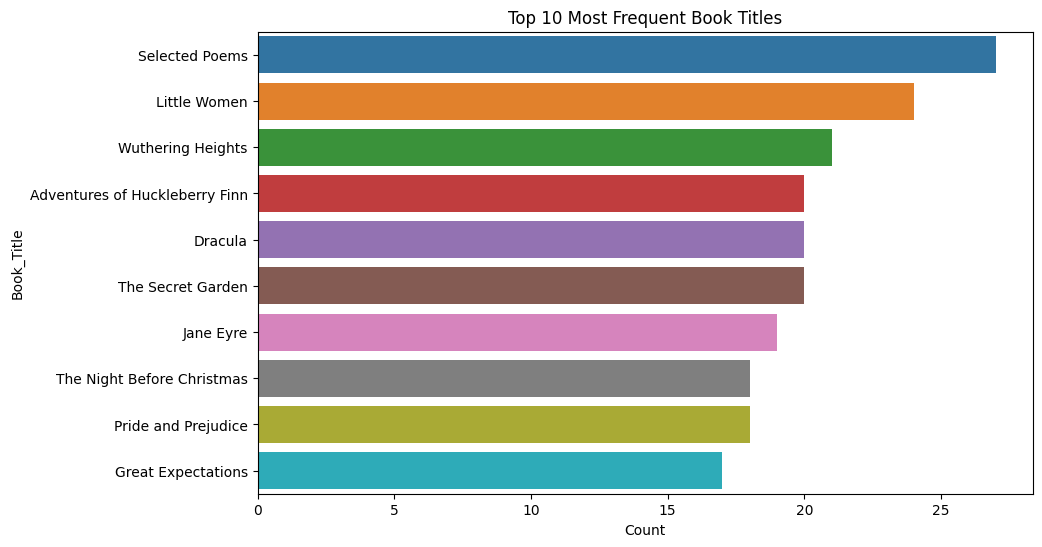

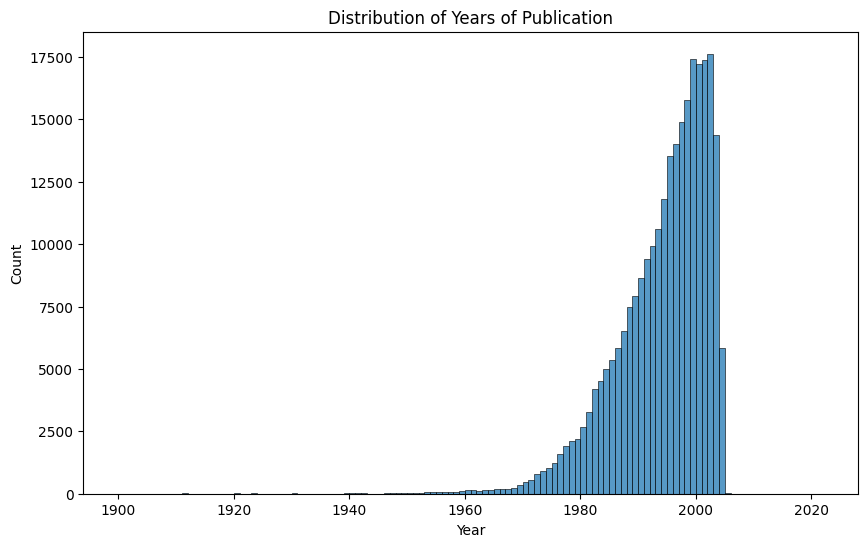

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot for Book Titles
plt.figure(figsize=(10, 6))
sns.countplot(y='Book_Title', data=book, order=book['Book_Title'].value_counts().index[:10])
plt.title('Top 10 Most Frequent Book Titles')
plt.xlabel('Count')
plt.show()

# Distribution of Years of Publication
plt.figure(figsize=(10, 6))
sns.histplot(book['Year_Of_Publication'].astype(int), bins=range(1900, 2023), kde=False)
plt.title('Distribution of Years of Publication')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


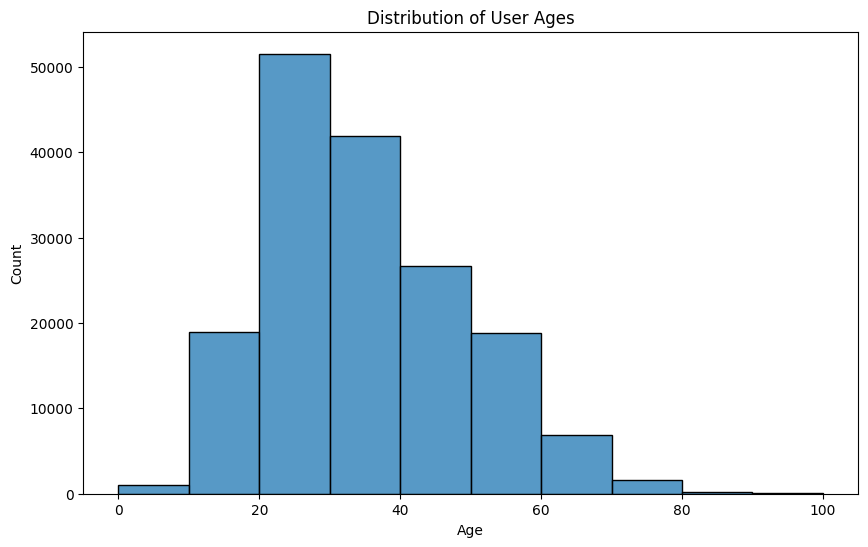

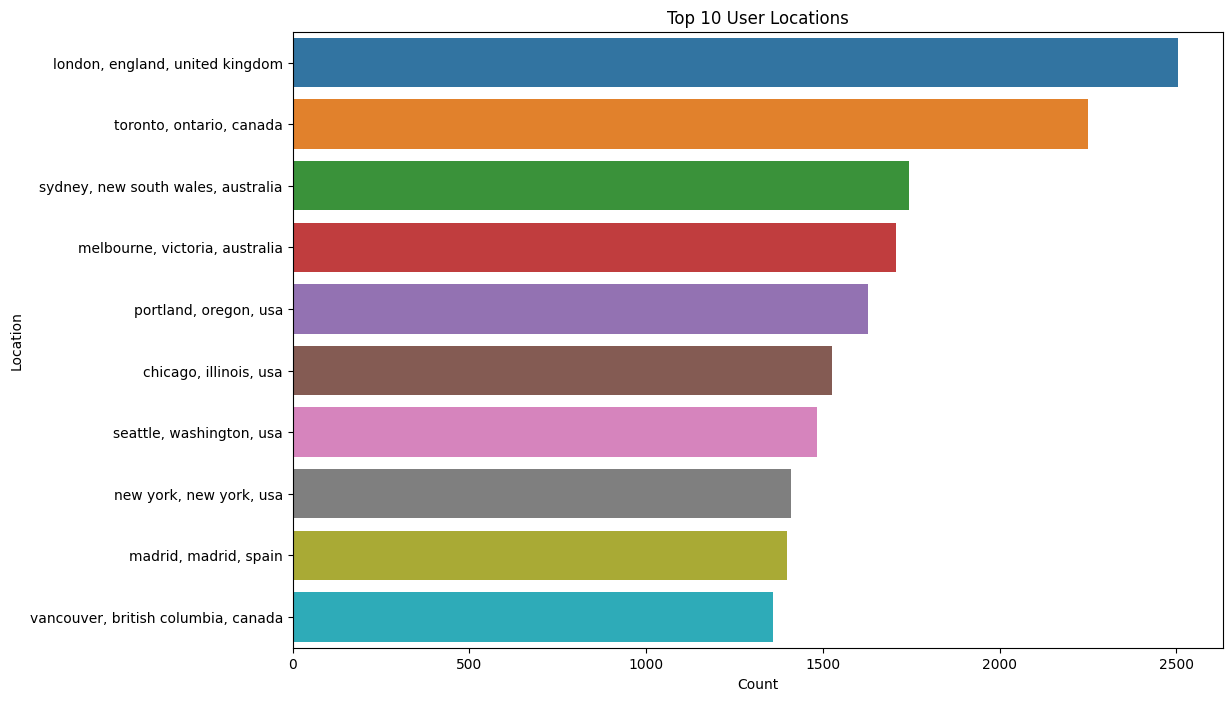

In [147]:
# Distribution of User Ages
plt.figure(figsize=(10, 6))
sns.histplot(User['Age'].dropna(), bins=range(0, 101, 10), kde=False)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Countplot for User Locations
plt.figure(figsize=(12, 8))
sns.countplot(y='Location', data=User, order=User['Location'].value_counts().index[:10])
plt.title('Top 10 User Locations')
plt.xlabel('Count')
plt.show()


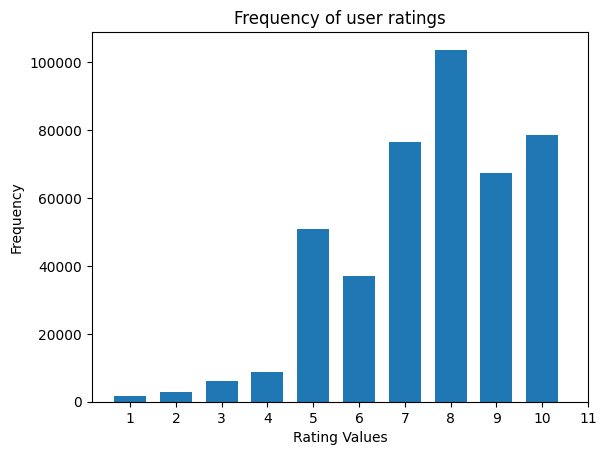

In [148]:
# Distribution of Book Ratings
data =Rating['Book_Rating']
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11]

plt.hist(data, bins, align="left", rwidth = 0.7)
plt.xticks(bins)
plt.xlabel('Rating Values')
plt.ylabel('Frequency')
plt.title('Frequency of user ratings')
plt.show()


C:\Users\astik\AppData\Local\Temp\ipykernel_16292\3874523952.py:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



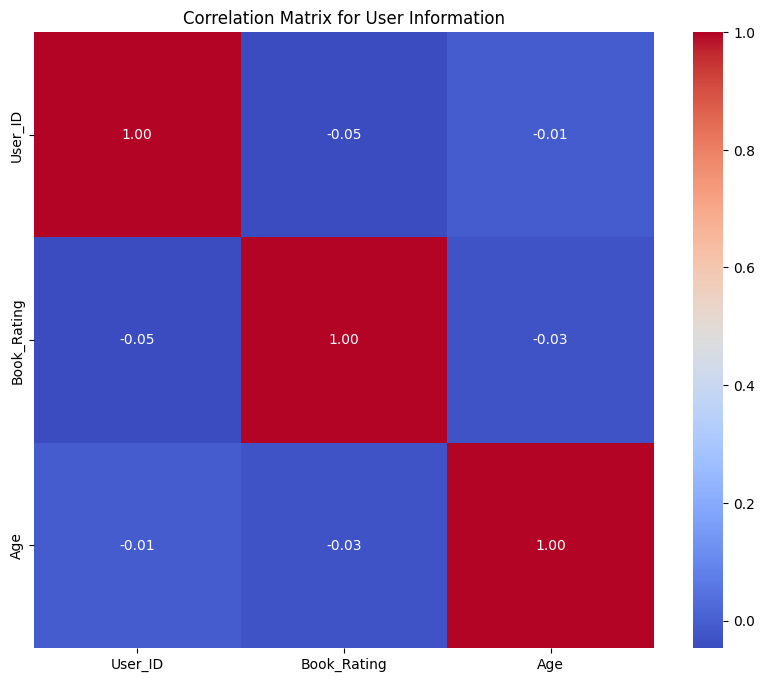

In [149]:
# Assuming 'user_info' is your DataFrame for user information
# If 'user_info' and other tables are in a dictionary, you can access it like user_info['User_ID']

# Merge the 'user_info' and 'rating' tables on 'User_ID'
merged_data = pd.merge(Rating, User, on='User_ID')

# Create a correlation matrix
correlation_matrix = merged_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for User Information')
plt.show()

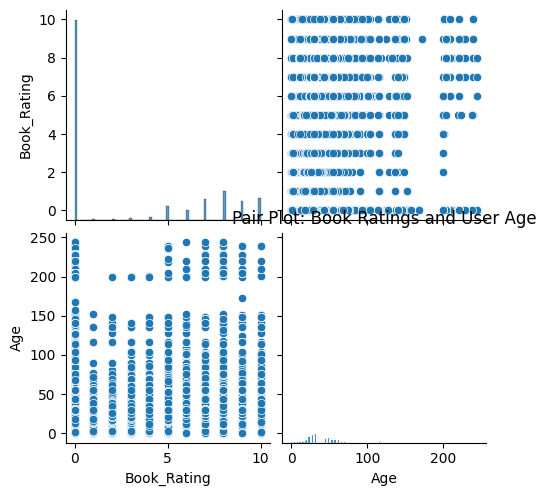

In [150]:
# Pair plot for Book Ratings and User Age
sns.pairplot(data=merged_data, vars=['Book_Rating', 'Age'])
plt.title('Pair Plot: Book Ratings and User Age')
plt.show()


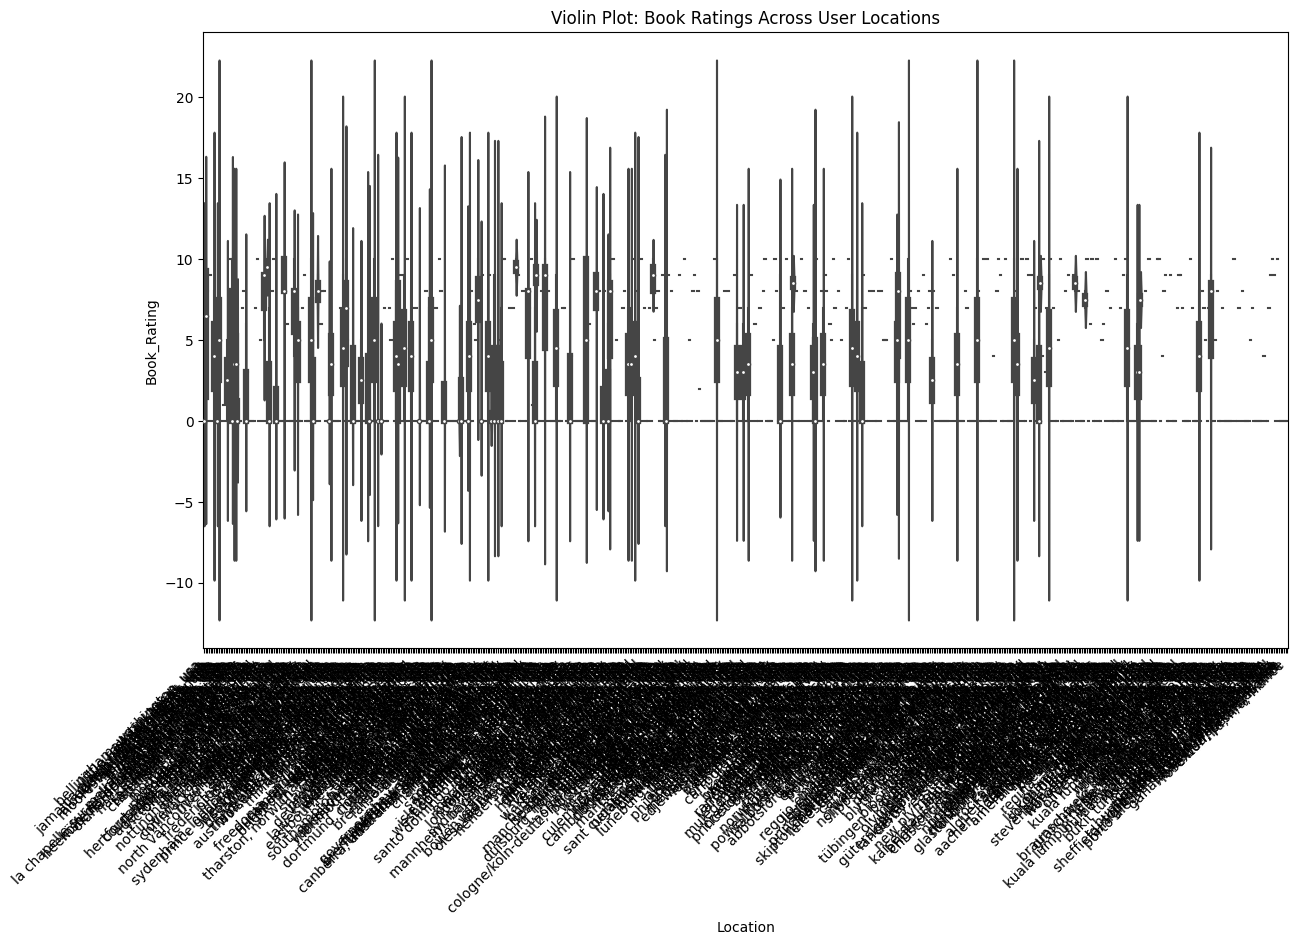

In [151]:
# Violin plot for Book Ratings across User Locations
plt.figure(figsize=(14, 8))
sns.violinplot(x='Location', y='Book_Rating', data=merged_data.sample(1000))  # Sample for better visibility
plt.title('Violin Plot: Book Ratings Across User Locations')
plt.xticks(rotation=45, ha='right')
plt.show()


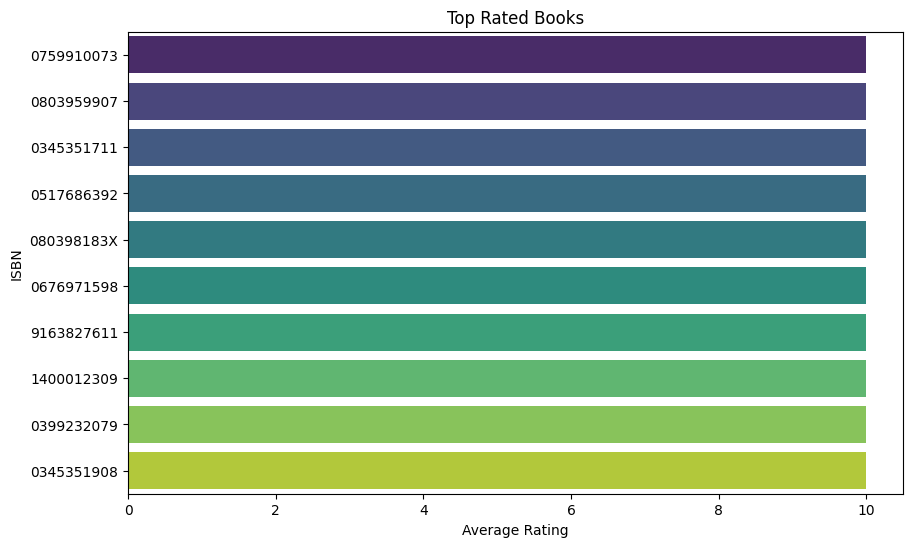

In [152]:
# Bar plot for top-rated books
top_rated_books = Rating.groupby('ISBN')['Book_Rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_rated_books.values, y=top_rated_books.index, palette='viridis')
plt.title('Top Rated Books')
plt.xlabel('Average Rating')
plt.show()


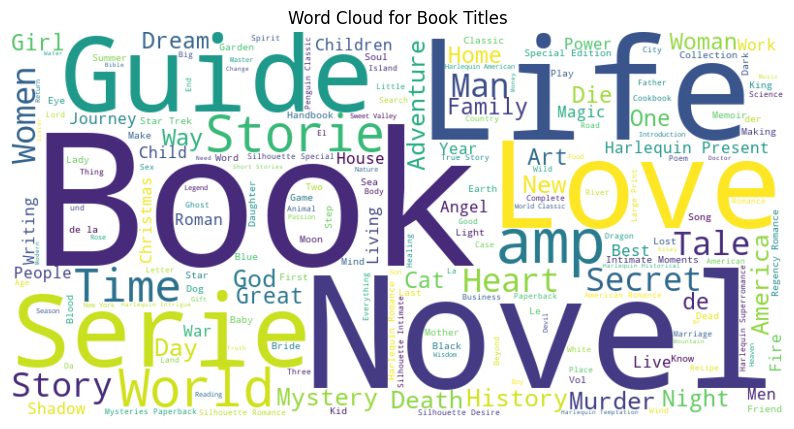

In [153]:
from wordcloud import WordCloud

# Generate word cloud for book titles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(book['Book_Title']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Book Titles')
plt.show()


In [154]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book_Title           271360 non-null  object
 2   Book_Author          271359 non-null  object
 3   Year_Of_Publication  271360 non-null  int64 
 4   Publisher            271358 non-null  object
 5   Image_URL_S          271360 non-null  object
 6   Image_URL_M          271360 non-null  object
 7   Image_URL_L          271357 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


In [155]:
import plotly.express as px

# Interactive scatter plot
fig = px.scatter(merged_data.sample(1000), x='Age', y='Book_Rating', color='Location', opacity=0.7, title='Interactive Scatter Plot: Age vs Book Rating')
fig.show()


# poularity base recommender system

In [156]:
ratings_W_name=Rating.merge(book,on='ISBN')

In [157]:
ratings_W_name

,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...,...,...
1031134,276688,0517145553,0,Mostly Harmless,Douglas Adams,1995,Random House Value Pub,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...
1031135,276688,1575660792,7,Gray Matter,Shirley Kennett,1996,Kensington Publishing Corporation,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...
1031136,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997,Apple,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...
1031137,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997,Vintage Books USA,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...


In [158]:
ratings_W_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031139 entries, 0 to 1031138
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User_ID              1031139 non-null  int64 
 1   ISBN                 1031139 non-null  object
 2   Book_Rating          1031139 non-null  int64 
 3   Book_Title           1031139 non-null  object
 4   Book_Author          1031138 non-null  object
 5   Year_Of_Publication  1031139 non-null  int64 
 6   Publisher            1031137 non-null  object
 7   Image_URL_S          1031139 non-null  object
 8   Image_URL_M          1031139 non-null  object
 9   Image_URL_L          1031135 non-null  object
dtypes: int64(3), object(7)
memory usage: 86.5+ MB


In [159]:
num_rating_df = ratings_W_name.groupby('Book_Title').count()['Book_Rating'].reset_index()
num_rating_df.rename(columns={'Book_Rating':'num_ratings'},inplace=True)
num_rating_df

,Book_Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1
2,Earth Prayers From around the World: 365 Pray...,10
3,Good Wives: Image and Reality in the Lives of...,10
4,Goosebumps Monster Edition 1: Welcome to Dead...,9
...,...,...
241062,Ã?Â?lpiraten.,2
241063,Ã?Â?rger mit Produkt X. Roman.,4
241064,Ã?Â?sterlich leben.,1
241065,Ã?Â?stlich der Berge.,3


In [160]:
avg_rating_df = ratings_W_name.groupby('Book_Title').mean()['Book_Rating'].reset_index()
avg_rating_df.rename(columns={'Book_Rating':'avg_rating'},inplace=True)
avg_rating_df

C:\Users\astik\AppData\Local\Temp\ipykernel_16292\1552062342.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Book_Title,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
2,Earth Prayers From around the World: 365 Pray...,5.000000
3,Good Wives: Image and Reality in the Lives of...,3.200000
4,Goosebumps Monster Edition 1: Welcome to Dead...,2.222222
...,...,...
241062,Ã?Â?lpiraten.,0.000000
241063,Ã?Â?rger mit Produkt X. Roman.,5.250000
241064,Ã?Â?sterlich leben.,7.000000
241065,Ã?Â?stlich der Berge.,2.666667


In [161]:
popular_df = num_rating_df.merge(avg_rating_df,on='Book_Title')
popular_df

,Book_Title,num_ratings,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.250000
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.000000
2,Earth Prayers From around the World: 365 Pray...,10,5.000000
3,Good Wives: Image and Reality in the Lives of...,10,3.200000
4,Goosebumps Monster Edition 1: Welcome to Dead...,9,2.222222
...,...,...,...
241062,Ã?Â?lpiraten.,2,0.000000
241063,Ã?Â?rger mit Produkt X. Roman.,4,5.250000
241064,Ã?Â?sterlich leben.,1,7.000000
241065,Ã?Â?stlich der Berge.,3,2.666667


In [162]:
popular_df = popular_df[popular_df['num_ratings']>=250].sort_values('avg_rating',ascending=False).head(10)

In [163]:
popular_df = popular_df.merge(book,on='Book_Title').drop_duplicates('Book_Title')[['Book_Title','Book_Author','Image_URL_M','num_ratings','avg_rating']]

In [164]:
popular_df.head(10)

,Book_Title,Book_Author,Image_URL_M,num_ratings,avg_rating
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.0...,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.0...,556,5.183453
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339681.0...,281,5.007117
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339703.0...,368,4.948370
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,http://images.amazon.com/images/P/059035342X.0...,575,4.895652
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339711.0...,260,4.880769
39,To Kill a Mockingbird,Harper Lee,http://images.amazon.com/images/P/0446310786.0...,510,4.700000


## Collaborative Filtering Based Recommender System Bse on Ratings

In [165]:
x = ratings_W_name.groupby('User_ID').count()['Book_Rating'] > 200
padhe_likhe_users = x[x].index

In [166]:
filtered_rating = ratings_W_name[ratings_W_name['User_ID'].isin(padhe_likhe_users)]

In [167]:
y = filtered_rating.groupby('Book_Title').count()['Book_Rating']>=50
famous_books = y[y].index

In [168]:
famous_books.unique()

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Day Late and a Dollar Short', 'A Fine Balance',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book_Title', length=706)

In [169]:
final_ratings = filtered_rating[filtered_rating['Book_Title'].isin(famous_books)]

In [170]:
pt = final_ratings.pivot_table(index='Book_Title',columns='User_ID',values='Book_Rating')

In [171]:
pt.fillna(0,inplace=True)

In [172]:
pt

User_ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book_Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
similarity_scores = cosine_similarity(pt)

In [174]:
similarity_scores.shape

(706, 706)

In [175]:
similarity_scores[1]

array([0.10255025, 1.        , 0.2364573 , 0.        , 0.1095379 ,
       0.10092909, 0.11786249, 0.18761978, 0.09658879, 0.04716095,
       0.09790994, 0.07830823, 0.19121955, 0.04828673, 0.11297907,
       0.11424415, 0.11290848, 0.08432401, 0.05619509, 0.09820417,
       0.17562977, 0.05779941, 0.15727218, 0.05719732, 0.11374482,
       0.        , 0.09515326, 0.08104912, 0.02894774, 0.07225874,
       0.01714222, 0.03288122, 0.04211669, 0.09380106, 0.04486288,
       0.25375719, 0.04682287, 0.20897363, 0.05826367, 0.30746648,
       0.05386542, 0.06892792, 0.04503831, 0.074284  , 0.13507508,
       0.05023148, 0.02267079, 0.06552582, 0.05644729, 0.06294081,
       0.07553841, 0.05578722, 0.        , 0.19483247, 0.07717041,
       0.01504361, 0.10744436, 0.05396449, 0.08539351, 0.10668897,
       0.11024468, 0.        , 0.02769053, 0.23980848, 0.08922627,
       0.04639526, 0.04350087, 0.09616002, 0.1153737 , 0.01531666,
       0.13588642, 0.03504529, 0.12520455, 0.12647968, 0.10989

In [176]:
def recommend(book_name):
    # index fetch
    index = np.where(pt.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = book[book['Book_Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Image_URL_M'].values))
        
        data.append(item)
    
    return data

In [177]:
recommend('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ["The Handmaid's Tale",
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg']]

## Collaborative Filtering Based Recommender System Bse on Age

In [178]:
U_W_name=User.merge(Rating,on='User_ID')

In [179]:
U_W_name.isnull().sum()

User_ID             0
Location            0
Age            309492
ISBN                0
Book_Rating         0
dtype: int64

In [180]:
book.isnull().sum()

ISBN                   0
Book_Title             0
Book_Author            1
Year_Of_Publication    0
Publisher              2
Image_URL_S            0
Image_URL_M            0
Image_URL_L            3
dtype: int64

In [181]:
b_W_name=U_W_name.merge(book,on='ISBN')

In [182]:
b_W_name.isnull().sum()

User_ID                     0
Location                    0
Age                    277835
ISBN                        0
Book_Rating                 0
Book_Title                  0
Book_Author                 1
Year_Of_Publication         0
Publisher                   2
Image_URL_S                 0
Image_URL_M                 0
Image_URL_L                 4
dtype: int64

In [183]:
b_W_name.isnull().sum()

User_ID                     0
Location                    0
Age                    277835
ISBN                        0
Book_Rating                 0
Book_Title                  0
Book_Author                 1
Year_Of_Publication         0
Publisher                   2
Image_URL_S                 0
Image_URL_M                 0
Image_URL_L                 4
dtype: int64

In [184]:
user_W_name=ratings_W_name.merge(User,on='User_ID')

In [185]:
user_W_name['ISBN'] = user_W_name['ISBN'].str.replace('X', '0')

In [186]:
# Convert 'Year_Of_Publication' to numeric, coercing non-numeric values to NaN
user_W_name['ISBN'] = pd.to_numeric(book['ISBN'], errors='coerce')

In [187]:
user_W_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031139 entries, 0 to 1031138
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User_ID              1031139 non-null  int64  
 1   ISBN                 249027 non-null   float64
 2   Book_Rating          1031139 non-null  int64  
 3   Book_Title           1031139 non-null  object 
 4   Book_Author          1031138 non-null  object 
 5   Year_Of_Publication  1031139 non-null  int64  
 6   Publisher            1031137 non-null  object 
 7   Image_URL_S          1031139 non-null  object 
 8   Image_URL_M          1031139 non-null  object 
 9   Image_URL_L          1031135 non-null  object 
 10  Location             1031139 non-null  object 
 11  Age                  753304 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 102.3+ MB


In [188]:
x = user_W_name.groupby('Age').count()['Book_Rating']> 200
padhe_likhe_users = x[x].index

In [189]:
filtered_rating2 = user_W_name[user_W_name['Age'].isin(padhe_likhe_users)]

In [190]:
y = filtered_rating2.groupby('Book_Title').count()['Age']>=18
famous_books1 = y[y].index

In [191]:
final_ratings2 = filtered_rating2[filtered_rating2['Book_Title'].isin(famous_books1)]

In [192]:
final_ratings2

,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L,Location,Age
1,2313,2005018.0,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"cincinnati, ohio, usa",23.0
2,2313,60973129.0,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,"cincinnati, ohio, usa",23.0
3,2313,374157065.0,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,"cincinnati, ohio, usa",23.0
4,2313,393045218.0,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,"cincinnati, ohio, usa",23.0
5,2313,399135782.0,5,The Mistress of Spices,Chitra Banerjee Divakaruni,1998,Anchor Books/Doubleday,http://images.amazon.com/images/P/0385482388.0...,http://images.amazon.com/images/P/0385482388.0...,http://images.amazon.com/images/P/0385482388.0...,"cincinnati, ohio, usa",23.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1030729,259589,NaN,8,Anthem,Ayn Rand,1966,Caxton Press,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,"venice, florida, usa",19.0
1030827,274282,NaN,10,1984,George Orwell,1998,La Marca Editora,http://images.amazon.com/images/P/8423328651.0...,http://images.amazon.com/images/P/8423328651.0...,http://images.amazon.com/images/P/8423328651.0...,"barcelona, alabama, spain",24.0
1030967,269629,NaN,8,The Big Picture,Tom Nelson,1996,Baxter Press,http://images.amazon.com/images/P/1888237007.0...,http://images.amazon.com/images/P/1888237007.0...,http://images.amazon.com/images/P/1888237007.0...,"carrollton, texas, usa",31.0
1030973,269923,NaN,0,The Falls,Ian Rankin,2001,Trafalgar Square,http://images.amazon.com/images/P/075282130X.0...,http://images.amazon.com/images/P/075282130X.0...,http://images.amazon.com/images/P/075282130X.0...,"derby, england, united kingdom",36.0


In [193]:
pt1 = final_ratings2.pivot_table(index='Book_Title',columns='Age',values='Book_Rating')

In [194]:
pt1.fillna(0,inplace=True)

In [195]:
pt1

Age,0.0,1.0,2.0,4.0,8.0,9.0,10.0,11.0,12.0,13.0,...,72.0,73.0,74.0,75.0,76.0,81.0,103.0,104.0,116.0,201.0
Book_Title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001 Ways to Be Romantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"14,000 Things to Be Happy About",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"\O\"" Is for Outlaw""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
similarity_scores1 = cosine_similarity(pt1)

In [197]:
similarity_scores1[0]

array([1.        , 0.05641345, 0.06244943, ..., 0.22185784, 0.20272742,
       0.37634467])

In [198]:
def recommend1(book_name):
    # index fetch
    index = np.where(pt1.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores1[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = book[book['Book_Title'] == pt1.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Image_URL_M'].values))
        
        data.append(item)
    
    return data

In [199]:
recommend1('1984')

[['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg'],
 ["The Hitchhiker's Guide to the Galaxy",
  'Douglas Adams',
  'http://images.amazon.com/images/P/0671461494.01.MZZZZZZZ.jpg'],
 ['Shopaholic Takes Manhattan (Summer Display Opportunity)',
  'Sophie Kinsella',
  'http://images.amazon.com/images/P/0385335881.01.MZZZZZZZ.jpg'],
 ['Anne Frank: The Diary of a Young Girl',
  'ANNE FRANK',
  'http://images.amazon.com/images/P/0553296981.01.MZZZZZZZ.jpg']]

## Collaborative Filtering Based Recommender System Bse on Location Based

In [200]:
x = user_W_name.groupby('User_ID').count()['Location'] < 70
padhe_likhe_users = x[x].index

In [201]:
filtered_rating3 = user_W_name[user_W_name['User_ID'].isin(padhe_likhe_users)]

In [202]:
y = filtered_rating3.groupby('Book_Title').count()['Location']>=18
famous_books3 = y[y].index

In [203]:
final_ratings3 = filtered_rating3[filtered_rating3['Book_Title'].isin(famous_books3)]

In [204]:
pt2 = final_ratings3.pivot_table(index='Book_Title',columns='User_ID',values='Age')

In [205]:
pt2.fillna(0,inplace=True)

In [206]:
pt2

User_ID,10,19,42,44,51,56,67,75,99,114,...,278807,278819,278820,278824,278832,278836,278843,278844,278846,278851
Book_Title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"\O\"" Is for Outlaw""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
similarity_scores2 = cosine_similarity(pt2)

In [208]:
similarity_scores2

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.05415689],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05415689, 0.        ,
        1.        ]])

In [229]:
def recommend2(book_name):
    # index fetch
    index = np.where(pt2.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores2[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = book[book['Book_Title'] == pt2.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Image_URL_M'].values))
        
        data.append(item)
    
    return data

In [230]:
recommend2('Animal Farm')

[['LIFE AFTER GOD : LIFE AFTER GOD',
  'Douglas Coupland',
  'http://images.amazon.com/images/P/0671874349.01.MZZZZZZZ.jpg'],
 ['Girlfriend in a Coma',
  'Douglas Coupland',
  'http://images.amazon.com/images/P/0060987324.01.MZZZZZZZ.jpg'],
 ['A Confederacy of Dunces',
  'John Kennedy Toole',
  'http://images.amazon.com/images/P/0517122707.01.MZZZZZZZ.jpg'],
 ['1984',
  'George Orwell',
  'http://images.amazon.com/images/P/0451524934.01.MZZZZZZZ.jpg']]

## experimat

In [211]:
user_W_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031139 entries, 0 to 1031138
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User_ID              1031139 non-null  int64  
 1   ISBN                 249027 non-null   float64
 2   Book_Rating          1031139 non-null  int64  
 3   Book_Title           1031139 non-null  object 
 4   Book_Author          1031138 non-null  object 
 5   Year_Of_Publication  1031139 non-null  int64  
 6   Publisher            1031137 non-null  object 
 7   Image_URL_S          1031139 non-null  object 
 8   Image_URL_M          1031139 non-null  object 
 9   Image_URL_L          1031135 non-null  object 
 10  Location             1031139 non-null  object 
 11  Age                  753304 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 102.3+ MB


In [212]:
ratings_W_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031139 entries, 0 to 1031138
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User_ID              1031139 non-null  int64 
 1   ISBN                 1031139 non-null  object
 2   Book_Rating          1031139 non-null  int64 
 3   Book_Title           1031139 non-null  object
 4   Book_Author          1031138 non-null  object
 5   Year_Of_Publication  1031139 non-null  int64 
 6   Publisher            1031137 non-null  object
 7   Image_URL_S          1031139 non-null  object
 8   Image_URL_M          1031139 non-null  object
 9   Image_URL_L          1031135 non-null  object
dtypes: int64(3), object(7)
memory usage: 86.5+ MB


In [213]:
x1 =ratings_W_name.groupby('Year_Of_Publication').count()['Book_Rating']>20
padhe_likhe_users1 = x1[x1].index

In [214]:
filtered_rating3 = user_W_name[user_W_name['Year_Of_Publication'].isin(padhe_likhe_users1)]

In [215]:
y = filtered_rating3.groupby('Book_Title').count()['Book_Rating']
famous_books4 = y[y].index

In [216]:
y

Book_Title
 A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)     4
 Ask Lily (Young Women of Faith: Lily Series, Book 5)                                                          1
 Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth              10
 Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750                       10
 Goosebumps Monster Edition 1: Welcome to Dead House, Stay Out of the Basement, and Say Cheese and Die!        9
                                                                                                              ..
Ã?Â?lpiraten.                                                                                                  2
Ã?Â?rger mit Produkt X. Roman.                                                                                 4
Ã?Â?sterlich leben.                                                                  

In [217]:
famous_books.unique()

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Day Late and a Dollar Short', 'A Fine Balance',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book_Title', length=706)

In [218]:
final_ratings3 = filtered_rating3[filtered_rating3['Book_Title'].isin(famous_books4)]

In [219]:
pt5 = final_ratings3.pivot_table(index='Book_Title',columns='Year_Of_Publication',values='Book_Rating')

In [220]:
pt5.fillna(0,inplace=True)

In [221]:
pt5

Year_Of_Publication,0,1951,1953,1959,1965,1966,1971,1972,1973,1974,...,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004
Book_Title,,,,,,,,,,,,,,,,,,,,,
"Ask Lily (Young Women of Faith: Lily Series, Book 5)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,8.0,0.0,0.0,0.0
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
"Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
"Goosebumps Monster Edition 1: Welcome to Dead House, Stay Out of the Basement, and Say Cheese and Die!",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.222222,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"20,000 Leagues Under the Sea (Wordsworth Collection)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,2.291667,0.0,0.0,0.0,0.0,0.0,0.0
"20-Minute Cookbook: 50 Delicious, Quick and Healthy Recipes (Step-By-Step)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2002 Writer's Market Online,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,8.0,0.0,0.0,0.0


In [222]:
pt5.index

Index([' Ask Lily (Young Women of Faith: Lily Series, Book 5)',
       ' Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth',
       ' Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750',
       ' Goosebumps Monster Edition 1: Welcome to Dead House, Stay Out of the Basement, and Say Cheese and Die!',
       ' Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)',
       ' Q-Space (Star Trek The Next Generation, Book 47)',
       ' Q-Zone (Star Trek The Next Generation, Book 48)',
       ' Summonings: Books of Magic, Vol. 2',
       ' The Secret of the Old Clock (Nancy Drew, Book 1)',
       ' Zap!: Science Fair Surprise! (Abracadabra!, Book 5)',
       ...
       '1600 Ventres',
       '1949 : A Novel of the Irish Free State (Irish Century)',
       '1984 : a novel',
       '1999 Guide to Literary Agents: 500 Agents Who Sell What You Write (Guide to Literary Agents)',
       '20 UNDER 30', '20,

In [284]:
def recommend1(column_name):
    
    #popular_df = popular_df[popular_df['num_ratings']>=250].sort_values('avg_rating',ascending=False).head(10)
    # index fetch
    index = np.where(pt5.columns==column_name)[0][0]
    sorted_dataframe = pt5.sort_values(by=column_name, ascending=False).index[:5]
    

    data = []
    for i in sorted_dataframe :
        
        item = []
        temp_df = book[book['Book_Title'] ==i] 
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Image_URL_M'].values))
        item
        
        data.append(item)
        
    
    return data

In [286]:
recommend1(1966)

[['... steigen aus... maschine brennt... 10 Fliegergeschichten.',
  'Roald Dahl',
  'http://images.amazon.com/images/P/3499108682.01.MZZZZZZZ.jpg'],
 [' Ask Lily (Young Women of Faith: Lily Series, Book 5)',
  'Nancy N. Rue',
  'http://images.amazon.com/images/P/0310232546.01.MZZZZZZZ.jpg'],
 ['100 Selected Poems by E. E. Cummings',
  'E. E. Cummings',
  'http://images.amazon.com/images/P/0802130720.01.MZZZZZZZ.jpg'],
 ["100 Secrets of the Smokies: A Guide to the Best Undiscovered Places in the Great Smoky Mountains Area (The Savvy Traveler's Guide)",
  'Randall Duckett',
  'http://images.amazon.com/images/P/1558535861.01.MZZZZZZZ.jpg'],
 ['100 Relationships That Shaped World History',
  'Samuel Crompton',
  'http://images.amazon.com/images/P/0912517409.01.MZZZZZZZ.jpg']]

In [255]:
column_name=2004


sorted_dataframe = pt5.sort_values(by=column_name, ascending=False).index[:5]
#a=sorted_dataframe.index[0:5]
#a
sorted_dataframe[1]

"'Til Death Do Us Part"

In [240]:


sorted_dataframe.index[2]

"'Tis Herself : A Memoir"

In [227]:
item = []
temp_df = book[book['Book_Title'] ==sorted_dataframe.index[0]] 
item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Title'].values))
item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Author'].values))
item.extend(list(temp_df.drop_duplicates('Book_Title')['Image_URL_M'].values))
item

['10 Things You Should Know About Dinosaurs (10 Things You Should Know series)',
 'Steve Parker',
 'http://images.amazon.com/images/P/1842361201.01.MZZZZZZZ.jpg']

In [228]:
column_name=2004

index = np.where(pt5.columns==column_name)[0][0]
sorted_dataframe = pt5.sort_values(by=column_name, ascending=False)[0:5]
data = []
for i =5 :
    item = []
    temp_df = book[book['Book_Title'] ==sorted_dataframe.index[i]] 
    item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Title'].values))
    item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Author'].values))
    item.extend(list(temp_df.drop_duplicates('Book_Title')['Image_URL_M'].values))
    
    
item

SyntaxError: invalid syntax (669701121.py, line 6)

In [ ]:
recommend('1966')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import pickle
pickle.dump(popular_df,open('popular.pkl','wb'))

In [ ]:
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(pt1,open('pt1.pkl','wb'))
pickle.dump(pt2,open('pt2.pkl','wb'))
pickle.dump(book,open('book.pkl','wb'))
pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))
pickle.dump(similarity_scores1,open('similarity_scores1.pkl','wb'))
pickle.dump(similarity_scores2,open('similarity_scores2.pkl','wb'))

In [ ]:
Rating['Book_Rating']

0           0
1           5
2           0
3           3
4           6
           ..
1149775     9
1149776     0
1149777    10
1149778    10
1149779     8
Name: Book_Rating, Length: 1149780, dtype: int64

# Train and evaluate

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
user_W_name['ISBN'] = label_encoder.fit_transform(user_W_name['ISBN'] )
user_W_name['Location'] = label_encoder.fit_transform(user_W_name['Location'])


In [ ]:
user_W_name['Age'].fillna(0, inplace=True)


In [ ]:
ratings_W_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031139 entries, 0 to 1031138
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User_ID              1031139 non-null  int64 
 1   ISBN                 1031139 non-null  object
 2   Book_Rating          1031139 non-null  int64 
 3   Book_Title           1031139 non-null  object
 4   Book_Author          1031138 non-null  object
 5   Year_Of_Publication  1031139 non-null  int64 
 6   Publisher            1031137 non-null  object
 7   Image_URL_S          1031139 non-null  object
 8   Image_URL_M          1031139 non-null  object
 9   Image_URL_L          1031135 non-null  object
dtypes: int64(3), object(7)
memory usage: 86.5+ MB


In [ ]:
user_W_name.loc[user_W_name['ISBN'] == '249026',:]


,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L,Location,Age


In [ ]:
user_W_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031139 entries, 0 to 1031138
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User_ID              1031139 non-null  int64  
 1   ISBN                 1031139 non-null  int64  
 2   Book_Rating          1031139 non-null  int64  
 3   Book_Title           1031139 non-null  object 
 4   Book_Author          1031138 non-null  object 
 5   Year_Of_Publication  1031139 non-null  int64  
 6   Publisher            1031137 non-null  object 
 7   Image_URL_S          1031139 non-null  object 
 8   Image_URL_M          1031139 non-null  object 
 9   Image_URL_L          1031135 non-null  object 
 10  Location             1031139 non-null  int32  
 11  Age                  1031139 non-null  float64
dtypes: float64(1), int32(1), int64(4), object(6)
memory usage: 98.3+ MB


In [ ]:
user_W_name.isnull().sum()

User_ID                0
ISBN                   0
Book_Rating            0
Book_Title             0
Book_Author            1
Year_Of_Publication    0
Publisher              2
Image_URL_S            0
Image_URL_M            0
Image_URL_L            4
Location               0
Age                    0
dtype: int64

In [ ]:

# Assume you have a dataset with user features, movie features, and a binary target variable 'Liked'
# Replace this with your actual dataset

# Creating a fictional dataset for illustration purposes
# Assume User_ID, Movie_ID, Age, and Location are features, and Liked is the binary target variable
X = user_W_name[['Book_Rating', 'Age', 'Location']]
y = user_W_name['ISBN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the kNN classifier
k = 3  # You can choose a different value for k
knn_classifier = KNeighborsClassifier(n_neighbors=k)
# Train the classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = knn_classifier.predict(X_test)
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report for more detailed evaluation
print(classification_report(y_test, predictions))

TypeError: train_test_split() got multiple values for argument 'test_size'

In [ ]:
predictions

array([249026, 249026,  75158, ..., 249026, 249026, 249026], dtype=int64)

In [ ]:
knn_classifier.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Make predictions on the test set
predictions = knn_classifier.predict(X_test)

In [ ]:
predictions = knn_classifier.predict(X_test)

In [ ]:
def recommend(book_name):
    # index fetch
    index = np.where(pt.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = book[book['Book_Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Book_Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book_Title')['Image_URL_M'].values))
        
        data.append(item)
    
    return data

In [ ]:
# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report for more detailed evaluation
print(classification_report(y_test, y_pred))

In [ ]:
# Train a RandomForestClassifier model
rf_model = RandomForestClassifier(n_estimators=1, random_state=42, max_leaf_nodes=10)

# Extract features and target variable
X_train = trainset_df.drop(['ISBN', 'Book_Rating', 'liked'], axis=1)
y_train = trainset_df['liked']

# Train the RandomForestClassifier model
rf_model.fit(X_train, y_train)



KeyError: "['liked'] not found in axis"

In [ ]:
# Extract features for the test set
X_test = testset_df.drop(['ISBN', 'Book_Rating', 'liked'], axis=1)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(predictions, testset_df['liked'])
print(f'Accuracy: {accuracy}')


In [ ]:
#Knn classifier model.


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a fictional movie dataset with additional features (age and location)

df = pd.DataFrame(data)

# Assume User_ID, Movie_ID, Age, and Location are features, and Rating is the target variable
X = user_W_name[['User_ID', 'ISBN', 'Age', 'Location']]
y = user_W_name['Rating']

# Convert categorical variable 'Location' to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['Location'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor for regression
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the regressor on the training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Evaluate the performance of the regressor using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Create a fictional movie dataset with features like Movie_ID, Title, Genre, etc.


df = pd.DataFrame(data)

# Assume the user provides a Movie_ID for which they want recommendations
user_input_movie_id = 102

# Extract features for the provided movie
user_input_movie_features = df[df['Movie_ID'] == user_input_movie_id]['Genre'].values[0]

# Use TF-IDF Vectorizer to convert text features (Genre) to numerical features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Genre'])

# Calculate cosine similarity between the provided movie and all other movies
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_vectorizer.transform([user_input_movie_features]))

# Get the top 10 most similar movies
similar_movies_indices = cosine_similarities[0].argsort()[:-11:-1]
recommended_movies = df.iloc[similar_movies_indices]['Title'].tolist()

print(f'Recommended movies for {user_input_movie_id}: {recommended_movies}')


In [ ]:
import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Assuming 'rating' is your DataFrame for user ratings
# Adjust column names as needed

# Load data into Surprise format
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(Rating[['User_ID', 'ISBN', 'Book_Rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Convert Surprise trainset and testset to DataFrames
trainset_df = pd.DataFrame(trainset.all_ratings(), columns=['User_ID', 'ISBN', 'Book_Rating'])
testset_df = pd.DataFrame(testset, columns=['User_ID', 'ISBN', 'Book_Rating'])

# Convert 'Book_Rating' to a binary variable (e.g., liked or not liked)
label_encoder = LabelEncoder()
trainset_df['liked'] = label_encoder.fit_transform(trainset_df['ISBN'] )
testset_df['liked'] = label_encoder.transform(testset_df['ISBN'] )

# Train a RandomForestClassifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Extract features and target variable
X_train = trainset_df.drop(['ISBN', 'Book_Rating', 'liked'], axis=1)
y_train = trainset_df['liked']

# Train the RandomForestClassifier model
rf_model.fit(X_train, y_train)

# Extract features for the test set
X_test = testset_df.drop(['ISBN', 'Book_Rating', 'liked'], axis=1)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(predictions, testset_df['liked'])
print(f'Accuracy: {accuracy}')


: 

In [ ]:

from surprise import SVD
from surprise import accuracy

# Assuming 'rating' is your DataFrame for user ratings
# Adjust column names as needed

# Load data into Surprise format
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(user_W_name[['Age','ISBN', 'Book_Rating']],reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

X_train = pd.DataFrame(trainset.all_ratings(), columns=['Age','ISBN', 'Book_Rating'])
y_train = X_train['Book_Rating']
X_train = X_train.drop('Book_Rating', axis=1)
# Train SVD model
svd_model = SVD()
svd_model.fit(y_train,X_train)

# Make predictions on the test set
predictions = svd_model.test(testset)


# Evaluate the model using accuracy
accuracy = accuracy_score(predictions, testset_df['liked'])
print(f'Accuracy: {accuracy}')

# Evaluate the model using RMSE
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')


TypeError: fit() takes exactly 2 positional arguments (3 given)

: 

In [ ]:
import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Assuming 'rating' is your DataFrame for user ratings
# Adjust column names as needed

# Load data into Surprise format
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(Rating[['User_ID', 'ISBN', 'Book_Rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train a collaborative filtering model (e.g., KNN)
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Convert the book data into a DataFrame
books_df = Rating[['ISBN', 'Book_Title']].drop_duplicates()

# Create a TF-IDF vectorizer for book titles
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['Book_Title'])

# Calculate cosine similarity between books based on titles
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get book recommendations based on input book name
def get_book_recommendations(book_name):
    book_index = books_df.index[books_df['Book_Title'] == book_name].tolist()[0]
    similar_books = list(enumerate(cosine_similarities[book_index]))
    similar_books = sorted(similar_books, key=lambda x: x[1], reverse=True)[1:6]
    similar_books_indices = [i[0] for i in similar_books]
    recommended_books = books_df['Book_Title'].iloc[similar_books_indices]
    return recommended_books

# Example: Get recommendations for a book
input_book_name = 'The Da Vinci Code'
recommendations = get_book_recommendations(input_book_name)
print(f'Recommended books for "{input_book_name}":')
print(recommendations)



 


: 

In [ ]:
trainset

: 

In [ ]:
from annoy import AnnoyIndex

: 

In [ ]:


# Load book features (word embeddings, etc.)
book_features = 

# Initialize Annoy index with appropriate dimensions
index = AnnoyIndex(len(book_features[0]), 'euclidean')

# Add books to the index
for i, book_feature in enumerate(book_features):
    index.add_item(i, book_feature)

# Build the index
index.build(10)

# Get recommendations for a user based on their profile
user_profile = ...
nearest_neighbors = index.get_nns_by_vector(user_profile, 10)

# Recommend books based on nearest neighbors
recommendations = [book_features[i] for i in nearest_neighbors]


: 

: 

: 